# Advanced Keras Tutorial 2

This notebook contains 

1) transfer learning. 

2) Multi-GPU and distributed training


In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.8', '1.3.0')

## Transfer Learning using Keras
### What is Transfer Learning?
Transfer learning is using a trained model from solving one problem and applying it to a different but related problem.
## Why Transfer Learning?
There are a few reasons we want to reuse pretrained models.  
- Training very Deep Networks with a large dataset is time consuming. The most complex models take weeks to train using  machines equipped with expensive GPUs. So you don't want to train a Convolution Neural network from scratch (random initialisation) 

- Determining the model architecture/training method/hyper parameters for deep learning is a black art.

- Sometime dataset is limited(for examples a few thousand images). So, using pre-trained network weights as a feature extractor helps in solving problems.
 Even with extreme data augmentation strategies it is difficult to achieve decent accuracy. Training these networks with millions of parameters generally tend to overfit the model. So Transfer learning comes to our rescue.

## How Transfer Learning helps ?
When you look at what these Deep Learning networks learn, they try to detect edges, shapes in the earlier layers and some high level data specific features in the later layers. These trained networks are generally helpful in solving other computer vision problems. Lets have a look at how to do transfer learning using Keras.
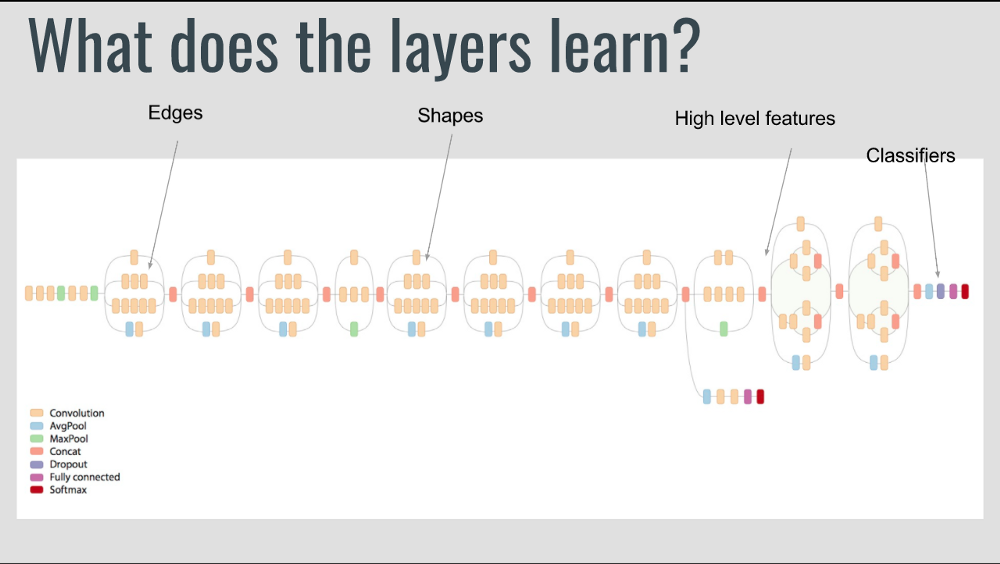

## Fine-tuning the top layers of a pre-trained network

keras provides some pre-trained models and weights. The pre-trained networks inside of Keras are capable of recongizing 1,000 different object categories, similar to objects we encounter in our daily lives with high accuracy.
Following is the list of pre-trained networks:

- VGG16
- VGG19
- ResNet50
- InceptionV3
- InceptionResNetV2
- Xception
- MobileNet  
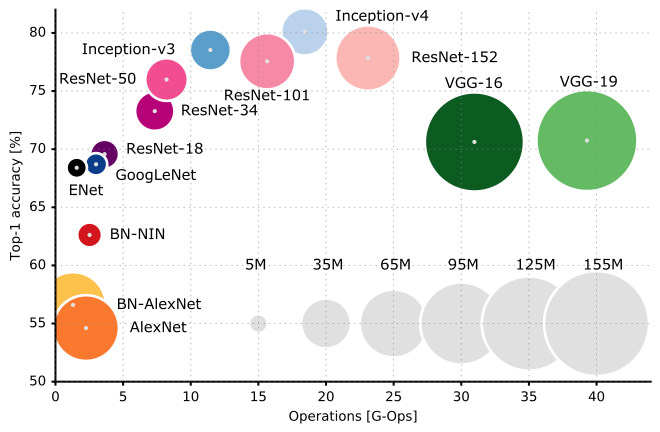


Xception has a smaller weight than VGG16, VGG19, ResNet50, InceptionV3
and InceptionResNetV2 at only 91MB. We can try to "fine-tune" a Xception model with a top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- instantiate the convolutional base of Xception and load its weights
- add some fully-connected model on top
- freeze the earlier layers of the Xception model up to the last convolutional block

Our setup: only 2000 training examples (1000 per class)
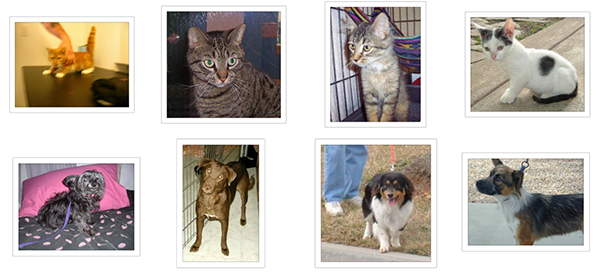

In [9]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.applications import InceptionV3, Xception
from keras import backend as K
import os
import numpy as np


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 200
batch_size = 64
data_augmentation = True
num_predictions = 20

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# build the Xception network
model = Xception(weights='imagenet', 
              include_top=False, 
              input_shape=(img_height, img_width, 3))
print('Model loaded.')

# set the layers (up to the 10 conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers:
    if layer.name.split("_")[0] not in ["block{}".format(i) for i in range(11, 15)]:
        layer.trainable = False
        print("trainable: {} : {}".format(layer.name, layer.trainable))

# build a classifier model to put on top of the convolutional model
top_model = model.output
top_model = GlobalAveragePooling2D(name='avg_pool')(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(model.input, top_model)

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

#call_backs
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

#callbacks
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_xception_trained_model.h5'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=5,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath=model_path,
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]
# Fit the model on the batches generated train_generator.
model.fit_generator(
    train_generator, 
    steps_per_epoch=2000 // float(batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= 800 // batch_size,
    workers=4,
    verbose=2,
    callbacks=callbacks)

Model loaded.
trainable: input_7 : False
trainable: block1_conv1 : False
trainable: block1_conv1_bn : False
trainable: block1_conv1_act : False
trainable: block1_conv2 : False
trainable: block1_conv2_bn : False
trainable: block1_conv2_act : False
trainable: block2_sepconv1 : False
trainable: block2_sepconv1_bn : False
trainable: block2_sepconv2_act : False
trainable: block2_sepconv2 : False
trainable: block2_sepconv2_bn : False
trainable: conv2d_25 : False
trainable: block2_pool : False
trainable: batch_normalization_25 : False
trainable: add_73 : False
trainable: block3_sepconv1_act : False
trainable: block3_sepconv1 : False
trainable: block3_sepconv1_bn : False
trainable: block3_sepconv2_act : False
trainable: block3_sepconv2 : False
trainable: block3_sepconv2_bn : False
trainable: conv2d_26 : False
trainable: block3_pool : False
trainable: batch_normalization_26 : False
trainable: add_74 : False
trainable: block4_sepconv1_act : False
trainable: block4_sepconv1 : False
trainable: blo

Epoch 54/200
 - 6s - loss: 0.3423 - acc: 0.8707 - val_loss: 0.3217 - val_acc: 0.8633
Epoch 55/200
 - 6s - loss: 0.3397 - acc: 0.8594 - val_loss: 0.3320 - val_acc: 0.8568
Epoch 56/200
 - 6s - loss: 0.3439 - acc: 0.8685 - val_loss: 0.3101 - val_acc: 0.8763
Epoch 57/200
 - 5s - loss: 0.3400 - acc: 0.8644 - val_loss: 0.3248 - val_acc: 0.8490
Epoch 58/200
 - 5s - loss: 0.3236 - acc: 0.8782 - val_loss: 0.3106 - val_acc: 0.8698
Epoch 59/200
 - 6s - loss: 0.3239 - acc: 0.8821 - val_loss: 0.2981 - val_acc: 0.8789
Epoch 60/200
 - 5s - loss: 0.3238 - acc: 0.8724 - val_loss: 0.3043 - val_acc: 0.8620
Epoch 61/200
 - 6s - loss: 0.3232 - acc: 0.8807 - val_loss: 0.3161 - val_acc: 0.8568
Epoch 62/200
 - 6s - loss: 0.3040 - acc: 0.8871 - val_loss: 0.3008 - val_acc: 0.8672
Epoch 63/200
 - 6s - loss: 0.3276 - acc: 0.8632 - val_loss: 0.2924 - val_acc: 0.8763
Epoch 64/200
 - 6s - loss: 0.3314 - acc: 0.8706 - val_loss: 0.2945 - val_acc: 0.8711
Epoch 65/200
 - 6s - loss: 0.3037 - acc: 0.8805 - val_loss: 0.291

We got about 92% accuracy with 100 epochs.

- we did not fine-tune the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last few blocks (more specialized features).
- fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

## Multiple GPUs

With muliple GPUs we can get close to linear speed up. 

Please note that your model may not run any faster on multiple GPUs if you are not actually GPU bound; some cases where this can happen include when you use a generator with your data and it‘s creation is CPU/IO bound, or if your model is not particularly complex and you are Memory-bound when transferring data to your GPU. You can use ```nvidia-smi``` or ```nvidia-settings``` to check your GPU usage if it lower than 90% you might be bottlenecked by CPU/IO.

```$ nvidia-smi```
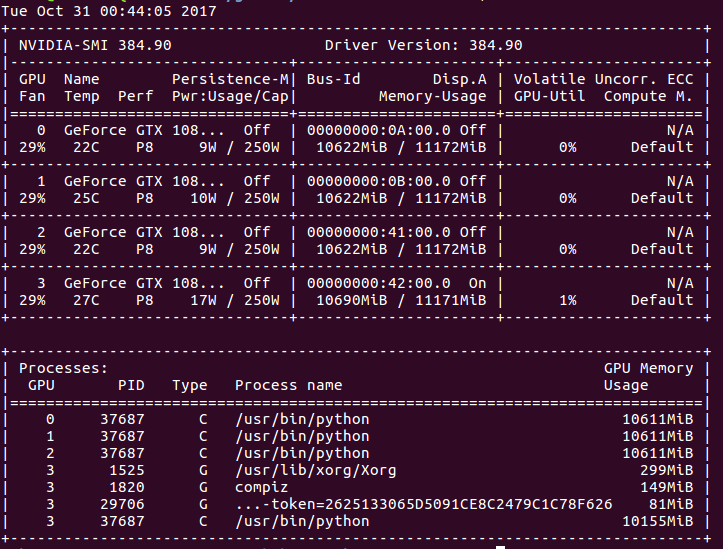

Currently keras only support multiple GPUs with tensorflow backend.
You need to install Keras from the Github source:
- First, clone Keras using git:  
```git clone https://github.com/fchollet/keras.git```
- Then, cd to the Keras folder and run the install command:  
```cd keras```
```sudo python setup.py instal```
lhttps://github.com/fchollet/keras/blob/3dd3e8331677e68e7dec6ed4a1cbf16b7ef19f7f/keras/utils/training_utils.py#L56-L75

Following is code to convert previous model to multiple GPUs.
Call tensorflow api to replicates a model on different GPUs.
Specifically, this function implements single-machine
multi-GPU data parallelism. It works in the following way:
- Divide the model's input(s) into multiple sub-batches.
- Apply a model copy on each sub-batch. Every model copy
is executed on a dedicated GPU.
- Concatenate the results (on CPU) into one big batch.
E.g. if your `batch_size` is 64x4 and you use `gpus=4`,
then we will divide the input into 4 sub-batches of 64 samples,
process each sub-batch on one GPU, then return the full
batch of 64x4 processed samples.
This induces quasi-linear speedup on up to 8 GPUs.

In [1]:
from keras.utils.training_utils import multi_gpu_model
from keras import backend as K
import tensorflow as tf
import os
import numpy as np
batch_size = 64*4

# Instantiate the base model
# (here, we do it on CPU, which is optional).
with tf.device('/cpu:0'):
    # build the Xception network
    model = Xception(weights='imagenet', 
              include_top=False, 
              input_shape=(img_height, img_width, 3))
    print('Model loaded.')

    # set the layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers:
        layer.trainable = False

    # build a classifier model to put on top of the convolutional model
    top_model = model.output
    top_model = GlobalAveragePooling2D(name='avg_pool')(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    model = Model(model.input, top_model)

# Replicates the model on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# This `fit` call will be distributed on 4 GPUs.
# Each GPU will process 64 samples.
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.fit_generator(
    train_generator, 
    steps_per_epoch=2000 // float(batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= 800 // batch_size,
    workers=32,
    verbose=2)


Using TensorFlow backend.


Model loaded.
Using real-time data augmentation.
Found 3000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50

7/7 [==============================] - ETA: 0s - loss: 0.7230 - acc: 0.4989 - val_loss: 0.6378 - val_acc: 0.6706
Epoch 2/50

7/7 [==============================] - ETA: 0s - loss: 0.7199 - acc: 0.4880 - val_loss: 0.6907 - val_acc: 0.5820
Epoch 3/50

7/7 [==============================] - ETA: 0s - loss: 0.7163 - acc: 0.5245 - val_loss: 0.6894 - val_acc: 0.5885
Epoch 4/50

7/7 [==============================] - ETA: 0s - loss: 0.7163 - acc: 0.5127 - val_loss: 0.6926 - val_acc: 0.5898
Epoch 5/50

7/7 [==============================] - ETA: 0s - loss: 0.7158 - acc: 0.5290 - val_loss: 0.6845 - val_acc: 0.5924
Epoch 6/50

7/7 [==============================] - ETA: 0s - loss: 0.7005 - acc: 0.5436 - val_loss: 0.6968 - val_acc: 0.5703
Epoch 7/50

7/7 [==============================] - ETA: 0s - loss: 0.7073 - acc: 0.5385 - val_loss: 0.6870 - val_acc: 

7/7 [==============================] - ETA: 0s - loss: 0.6793 - acc: 0.5999 - val_loss: 0.6946 - val_acc: 0.5586
Epoch 15/50

7/7 [==============================] - ETA: 0s - loss: 0.6928 - acc: 0.5930 - val_loss: 0.6881 - val_acc: 0.5755
Epoch 16/50

7/7 [==============================] - ETA: 0s - loss: 0.6785 - acc: 0.6166 - val_loss: 0.6797 - val_acc: 0.5911
Epoch 17/50

7/7 [==============================] - ETA: 0s - loss: 0.6688 - acc: 0.6218 - val_loss: 0.6910 - val_acc: 0.5729
Epoch 18/50

7/7 [==============================] - ETA: 0s - loss: 0.6596 - acc: 0.6395 - val_loss: 0.6866 - val_acc: 0.5742
Epoch 19/50

7/7 [==============================] - ETA: 0s - loss: 0.6677 - acc: 0.6289 - val_loss: 0.6767 - val_acc: 0.6003
Epoch 20/50

7/7 [==============================] - ETA: 0s - loss: 0.6795 - acc: 0.6172 - val_loss: 0.6967 - val_acc: 0.5599
Epoch 21/50

7/7 [==============================] - ETA: 0s - loss: 0.6662 - acc: 0.6244 - val_loss: 0.6837 - val_acc: 0.5716
Epoch

7/7 [==============================] - ETA: 0s - loss: 0.6510 - acc: 0.6440 - val_loss: 0.6795 - val_acc: 0.5964
Epoch 29/50

7/7 [==============================] - ETA: 0s - loss: 0.6447 - acc: 0.6618 - val_loss: 0.6799 - val_acc: 0.5833
Epoch 30/50

7/7 [==============================] - ETA: 0s - loss: 0.6591 - acc: 0.6490 - val_loss: 0.6881 - val_acc: 0.5742
Epoch 31/50

7/7 [==============================] - ETA: 0s - loss: 0.6442 - acc: 0.6535 - val_loss: 0.6783 - val_acc: 0.5768
Epoch 32/50

7/7 [==============================] - ETA: 0s - loss: 0.6524 - acc: 0.6496 - val_loss: 0.6849 - val_acc: 0.5664
Epoch 33/50

7/7 [==============================] - ETA: 0s - loss: 0.6472 - acc: 0.6591 - val_loss: 0.6852 - val_acc: 0.5599
Epoch 34/50

7/7 [==============================] - ETA: 0s - loss: 0.6320 - acc: 0.6774 - val_loss: 0.6798 - val_acc: 0.5690
Epoch 35/50

7/7 [==============================] - ETA: 0s - loss: 0.6396 - acc: 0.6546 - val_loss: 0.6746 - val_acc: 0.5781
Epoch

7/7 [==============================] - ETA: 0s - loss: 0.6204 - acc: 0.6970 - val_loss: 0.6605 - val_acc: 0.5872
Epoch 43/50

7/7 [==============================] - ETA: 0s - loss: 0.6284 - acc: 0.6868 - val_loss: 0.6644 - val_acc: 0.5794
Epoch 44/50

7/7 [==============================] - ETA: 0s - loss: 0.6197 - acc: 0.6853 - val_loss: 0.6555 - val_acc: 0.6042
Epoch 45/50

7/7 [==============================] - ETA: 0s - loss: 0.6196 - acc: 0.6809 - val_loss: 0.6512 - val_acc: 0.6120
Epoch 46/50

7/7 [==============================] - ETA: 0s - loss: 0.6318 - acc: 0.6791 - val_loss: 0.6606 - val_acc: 0.5951
Epoch 47/50

7/7 [==============================] - ETA: 0s - loss: 0.6188 - acc: 0.6946 - val_loss: 0.6628 - val_acc: 0.5938
Epoch 48/50

7/7 [==============================] - ETA: 0s - loss: 0.6119 - acc: 0.6920 - val_loss: 0.6527 - val_acc: 0.6016
Epoch 49/50

7/7 [==============================] - ETA: 0s - loss: 0.6215 - acc: 0.6814 - val_loss: 0.6622 - val_acc: 0.5794
Epoch

## Distributed training
You can make use of TensorFlow distributed training by registering with Keras a TF session linked to a cluster:

In [ ]:
server = tf.train.Server.create_local_server()
sess = tf.Session(server.target)

K.set_session(sess)

For more information about using TensorFlow in a distributed setting, see this tutorial https://www.tensorflow.org/deploy/distributed. 